[Kaggle dataset](https://www.kaggle.com/datasets/rmisra/news-category-dataset)

This is a dataset of news headlines and their categories. In this problem, we will tokenize the dataset on each word and feed it as sequence data into various models.

The dataset is not split and is in JSON format, requiring heavy preprocessing to be loaded by Keras. I also use the `tf.data` API to load data in a RAM-efficient manner.

# Preprocessing

## Load data

In [ ]:
import pandas as pd
import tensorflow as tf

In [ ]:
df = pd.read_json(
    './data/News_Category_Dataset_v3.json',
    dtype={'category': 'category'},
    lines=True
)
df = df[['headline', 'category']]

## Preprocess data

Save to file for Keras text dataset handling:

In [ ]:
import os
import re
from pathlib import Path
from sklearn.model_selection import train_test_split

def remove_special_characters(input_string):
    return re.sub('[^A-Za-z0-9]+', '', input_string)

def save_row_subset(subset):
    if subset != 'train' and subset != 'test':
        raise ValueError('Must be one of {train, test}')
    return lambda row: save_row(row, subset)

def save_row(row, subset):
    label = row['category']
    headline = row['headline']
    idx = row.name
    save_path_root = Path(f'./data/ByCategory/{subset}/{remove_special_characters(label)}').resolve()
    if not os.path.isdir(save_path_root):
        os.makedirs(save_path_root)
    save_path = save_path_root / f'{idx}.txt'
    
    with open(save_path, 'w') as f:
        f.write(headline + "\n")


train_df, test_df = train_test_split(df, test_size=0.20, random_state=42)

train_df.apply(save_row_subset('train'), axis=1)
test_df.apply(save_row_subset('test'), axis=1)

128310    None
139983    None
42339     None
131494    None
163649    None
          ... 
91721     None
10964     None
140604    None
182108    None
28078     None
Length: 41906, dtype: object

Create Keras datasets:

In [ ]:
BATCH_SIZE = 128
seed = 42

# load into TF dataset
raw_train_ds, raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    './data/ByCategory/train',
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    validation_split=0.1,
    subset='both',
    seed=seed
)

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    './data/ByCategory/test',
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    seed=seed
)

Found 167621 files belonging to 42 classes.
Using 150859 files for training.
Using 16762 files for validation.
Found 41906 files belonging to 42 classes.


Vectorize data:

In [ ]:
# vectorize sequences to length 120
VOCAB_SIZE = 200000
MAX_SEQUENCE_LENGTH = 120

vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH
)

train_text = raw_train_ds.map(lambda text, labels: text)
val_text = raw_val_ds.map(lambda text, labels: text)
vectorize_layer.adapt(train_text)
vectorize_layer.adapt(val_text)

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

AUTOTUNE = tf.data.AUTOTUNE

def configure_dataset(dataset):
    return dataset.cache().prefetch(buffer_size=AUTOTUNE)

train_ds = configure_dataset(raw_train_ds.map(vectorize_text))
val_ds = configure_dataset(raw_val_ds.map(vectorize_text))
test_ds = configure_dataset(raw_test_ds.map(vectorize_text))

## Visualize class distribution

<Axes: title={'center': 'Category Distribution'}>

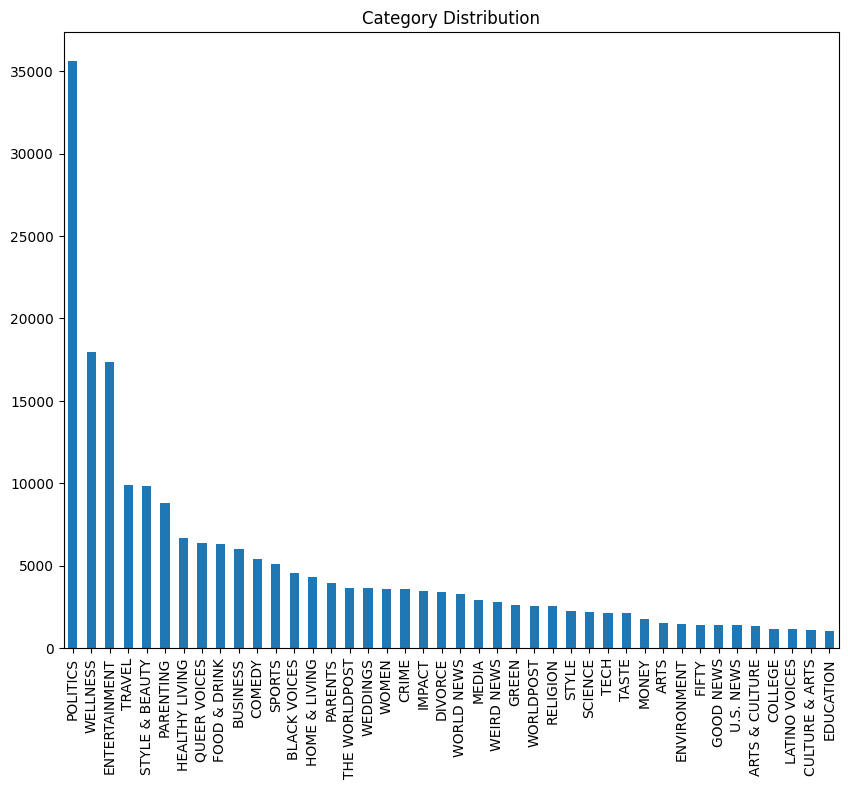

In [ ]:
df['category'].value_counts().plot.bar(figsize=(10,8), title="Category Distribution")

We can see that most of the articles in the dataset are politics, followed by wellness, entertainment, travel, then style and beauty. However, there are disproportionately more politics articles, which may affect classification accuracy.


The model should be able to predict the category of a new article given its headline. This can be used in news aggregator websites to determine under which section to put an article under.

# Train basic sequential model

## Define helper function to create models

We will use this to create models in a quick and easy manner, abstracting away the training and evaluation steps in a standardized manner.

In [ ]:
# helper function to create models
def eval_model(middle_layers, model_name='model', embedding_size=128, has_lstm=False, lstm_size=30, num_epochs=10, random_seed=42, return_model=False):
    tf.keras.utils.set_random_seed(random_seed)
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(120,)))
    model.add(tf.keras.layers.Embedding(VOCAB_SIZE + 1, embedding_size, mask_zero=True))
    if not has_lstm:
        model.add(tf.keras.layers.Flatten())
    else:
        model.add(tf.keras.layers.LSTM(lstm_size))
    if middle_layers is not None:
        for layer in middle_layers:
            model.add(layer)
    model.add(tf.keras.layers.Dense(42, activation='relu'))
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        optimizer='adam',
        metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
    )
    model.summary()
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=num_epochs
    )
    test_loss, test_acc, test_precision, test_recall = model.evaluate(test_ds)
    train_loss, train_acc, train_precision, train_recall = history.history['loss'][-1], history.history['accuracy'][-1], history.history['precision'][-1], history.history['recall'][-1]
    val_loss, val_acc, val_precision, val_recall = history.history['val_loss'][-1], history.history['val_accuracy'][-1], history.history['val_precision'][-1], history.history['val_recall'][-1]

    metrics = {
        'model_name': model_name,
        'train_loss': train_loss,
        'train_acc': train_acc,
        'train_precision': train_precision,
        'train_recall': train_recall,
        'train_f1': 2 * (train_precision * train_recall) / (train_precision + train_recall),
        'test_loss': test_loss,
        'test_acc': test_acc,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': 2 * (test_precision * test_recall) / (test_precision + test_recall),
        'val_loss': val_loss,
        'val_acc': val_acc,
        'val_precision': test_precision,
        'val_recall': test_recall,
        'val_f1': 2 * (val_precision * val_recall) / (val_precision + val_recall),
    }

    if return_model:
        return model, metrics
    return metrics

# Basic model creation

This simple sequential model has a 128-dimensional embedding with a flattening layer, 2 dense layers with 100 units each, sandwiched between a 20% dropout layer, and an output layer of 42 units.

In [ ]:
seq_1_model, seq_1_metrics = eval_model([
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(100, activation='relu')
], return_model=True, model_name='sequential_model_basic')

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 120, 128)          25600128  
                                                                 
 flatten_8 (Flatten)         (None, 15360)             0         
                                                                 
 dense_24 (Dense)            (None, 100)               1536100   
                                                                 
 dropout_8 (Dropout)         (None, 100)               0         
                                                                 
 dense_25 (Dense)            (None, 100)               10100     
                                                                 
 dense_26 (Dense)            (None, 42)                4242      
                                                                 
Total params: 27,150,570
Trainable params: 27,150,570


# Train LSTM model

This simple LSTM model has a 128-dimensional embedding, a 30-unit LSTM layer, and a 100-unit dense layer with an output layer of 42 units.

In [31]:
lstm_1_model, lstm_1_metrics = eval_model([
    tf.keras.layers.Dense(100, activation='relu'),
], has_lstm=True, return_model=True, model_name='lstm_model_basic')

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 120, 128)          25600128  
                                                                 
 lstm_1 (LSTM)               (None, 30)                19080     
                                                                 
 dense_29 (Dense)            (None, 100)               3100      
                                                                 
 dense_30 (Dense)            (None, 42)                4242      
                                                                 
Total params: 25,626,550
Trainable params: 25,626,550
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1179/1179 [==============================] - 55s 33ms/step - loss: 2.4751 - accuracy: 0.3962 - precision: 0.0873 - recall: 0.6701 - val_loss: 2.0761 - val_accurac

# Create larger embeddings for both models

These models are the same as the ones above, just with larger embeddings.

In [32]:
seq_2_model, seq_2_metrics = eval_model([
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(100, activation='relu')
], return_model=True, embedding_size=256, model_name='sequential_model_basic_big_embedding')

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 120, 256)          51200256  
                                                                 
 flatten_9 (Flatten)         (None, 30720)             0         
                                                                 
 dense_31 (Dense)            (None, 100)               3072100   
                                                                 
 dropout_9 (Dropout)         (None, 100)               0         
                                                                 
 dense_32 (Dense)            (None, 100)               10100     
                                                                 
 dense_33 (Dense)            (None, 42)                4242      
                                                                 
Total params: 54,286,698
Trainable params: 54,286,698

In [34]:
lstm_2_model, lstm_2_metrics = eval_model([
    tf.keras.layers.Dense(100, activation='relu'),
], has_lstm=True, embedding_size=256, return_model=True, model_name='lstm_model_basic_big_embedding')

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 120, 256)          51200256  
                                                                 
 lstm_3 (LSTM)               (None, 30)                34440     
                                                                 
 dense_36 (Dense)            (None, 100)               3100      
                                                                 
 dense_37 (Dense)            (None, 42)                4242      
                                                                 
Total params: 51,242,038
Trainable params: 51,242,038
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1179/1179 [==============================] - 51s 38ms/step - loss: 2.4599 - accuracy: 0.4175 - precision: 0.0886 - recall: 0.6511 - val_loss: 2.0810 - val_accurac

# Bigger LSTM model

LSTM model with larger embeddings, more LSTM units, and similar dense layer config as the sequential one.

In [35]:
lstm_3_model, lstm_3_metrics = eval_model([
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(100, activation='relu')
], has_lstm=True, lstm_size=100, embedding_size=256, return_model=True, model_name='lstm_model_large')

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 120, 256)          51200256  
                                                                 
 lstm_4 (LSTM)               (None, 100)               142800    
                                                                 
 dense_38 (Dense)            (None, 100)               10100     
                                                                 
 dropout_10 (Dropout)        (None, 100)               0         
                                                                 
 dense_39 (Dense)            (None, 100)               10100     
                                                                 
 dense_40 (Dense)            (None, 42)                4242      
                                                                 
Total params: 51,367,498
Trainable params: 51,367,498

# Compare and analyze models

In [37]:
model_metrics = pd.DataFrame.from_records([
    seq_1_metrics, seq_2_metrics, lstm_1_metrics, lstm_2_metrics, lstm_3_metrics
])
model_metrics

,model_name,train_loss,train_acc,train_precision,train_recall,train_f1,test_loss,test_acc,test_precision,test_recall,test_f1,val_loss,val_acc,val_precision,val_recall,val_f1
0,sequential_model_basic,1.392291,0.646750,0.356972,0.660458,0.463452,3.358078,0.415263,0.264149,0.526249,0.351742,3.336539,0.433659,0.264149,0.526249,0.356605
1,sequential_model_basic_big_embedding,1.332598,0.661757,0.305888,0.675704,0.421132,3.214554,0.416026,0.258409,0.515129,0.344170,3.207735,0.430319,0.258409,0.515129,0.347401
2,lstm_model_basic,1.230588,0.697850,0.293503,0.741819,0.420596,2.791766,0.472271,0.244146,0.626211,0.351320,2.882399,0.477509,0.244146,0.626211,0.349655
3,lstm_model_basic_big_embedding,1.219402,0.700601,0.336535,0.721972,0.459079,2.982210,0.470816,0.265722,0.588221,0.366075,3.074434,0.474406,0.265722,0.588221,0.361052
4,lstm_model_large,1.607377,0.603603,0.346931,0.623052,0.445690,3.021123,0.445521,0.291802,0.512600,0.371898,3.100049,0.449648,0.291802,0.512600,0.374125


Each model has metrics for loss, accuracy, precision, recall, and $F_1$ score for the train, test, and validation sets. We can see that the `lstm_model_large` performed the best when compared in $F_1$ score to the others. Even though the accuracy is about 3% lower on the test set than the next best performing model (`lstm_model_basic`), we accept this tradeoff for better classification performance given the imblanced dataset.

If we wanted to perform better, we may try using pretrained word embeddings to capture semantic word meanings in order to boost classification performance.

Overall, the problem of predicting categories from just a headline proved to be hard to improve performance on, and a larger model does better in $F_1$ metrics while sometimes sacrificing accuracy.